# Homework 4

#### Importation

In [763]:
#This is the importation cell

import numpy as np
import matplotlib.pyplot as plt
import time

#### Network, AD, and Gradient Descent Cells

In [764]:
#This cell defines the network architecture

inputNo = 2
outputNo = 1
networkLayers = np.array([inputNo , 10 , 10 , 10 , outputNo])
forwardNo = (networkLayers).shape[0] - 1

In [765]:
#This cell holds all network functions. Look to following cell for explanation of some things

def initNetwork(): #Initialize network

    weightsList = []

    biasesList = []

    for i in range(forwardNo):

        weightsList.append(initLayerWeights(networkLayers[i] , networkLayers[i+1]))

        biasesList.append(initLayerBiases(networkLayers[i+1])) 

    return weightsList , biasesList


def initLayerWeights(inNo , outNo): #Initialize Weights of a layer

    return (np.random.rand(1 , outNo , inNo)*20) - 10


def initLayerBiases(outNo): #Initialize Biases of a layer

    return (np.random.rand(1 , outNo , 1)*20) - 10


def activationFunction(input): #The Activation function

    #return np.greater(input , 0)*input #Relu

    return (2/(1 + np.exp(-input)))#2 times a sigmoid (for output range)


def activationFunctionDerivative(input): #The derivative of the Activation function

    #return np.greater(input , 0)*1.0 #Relu's Derivative

    return 2*(1/(1 + np.exp(-input))) * ( 1 - ( 1/(1 + np.exp(-input)))) #Derivative of 22 times a sigmoid


def forward(weightsList , biasesList , input): #This function does a forward pass with no graph calculation

    for i in range(forwardNo):

        input = activationFunction(weightsList[i]@input + biasesList[i])

    return input


def lossFunction(output , groundTruth): #This is the loss function (MSE)

    return np.square(output - groundTruth)


def lossFunctionDerivative(output , groundTruth): #This is the derivative of the loss function

    return 2*(output - groundTruth)


def forwardWithGraphCalculation(weightsList , biasesList , input , groundTruth , batchSize): #This is the forward pass with graph calculations

    ds_dw_list = []

    ds_db_list = []

    da_ds_list = []

    ds_da_list = []

    a = input

    for i in range(forwardNo):

        ds_dw_list.append(np.concatenate([np.transpose(a , axes = (0,2,1))]*networkLayers[i+1] , 1))

        ds_da_list.append(np.concatenate([weightsList[i]]*batchSize , 0))

        ds_db_list.append(np.ones((batchSize , networkLayers[i+1] ,1)))

        s = (weightsList[i]@a + biasesList[i])

        da_ds_list.append(activationFunctionDerivative(s))

        a = activationFunction(s)

    losses = lossFunction(a , groundTruth)

    dl_da = lossFunctionDerivative(a , groundTruth)

    return a , ds_dw_list , ds_db_list , da_ds_list , ds_da_list , losses , dl_da


def forwardAD_dl_dws(ds_dw_list , ds_db_list , da_ds_list , ds_da_list , dl_da , batchSize): #This function calculates the gradient of loss
                                                                                             #wrt. all weights and biases using forward AD
    da_dw_list = []

    dap_dam_list = []

    dl_dw_list = []

    daf_dai_list = []

    dl_dw_list = []

    da_db_list = []

    dl_db_list = []

    for i in range(forwardNo):

        da_dw_list.append(np.multiply(ds_dw_list[i] , da_ds_list[i]))

        dap_dam_list.append(np.multiply(ds_da_list[i] , da_ds_list[i]))

        da_db_list.append(np.multiply(ds_db_list[i] , da_ds_list[i]))

    for i in range(forwardNo):

        ident = np.stack([np.identity(da_dw_list[i].shape[1])]*batchSize , 0)

        da_db = np.multiply( ident , da_db_list[i])

        da_dw = np.multiply( ident , np.expand_dims(da_dw_list[i][:,:,0],axis = 2)) #Converts da_dw_list matrix to a matrix that can be multiplied through

        for j in range(da_dw_list[i].shape[2]-1):

            da_dw = np.concatenate((da_dw , np.multiply( ident , np.expand_dims(da_dw_list[i][:,:,j+1],axis = 2))) , axis = 2)

        for j in range(forwardNo-i-1):

            id = j+i


            da_dw = dap_dam_list[id+1]@da_dw

            da_db = dap_dam_list[id+1]@da_db


        dl_dw = dl_da@da_dw

        dl_db = dl_da@da_db

        dl_dw_list.append(np.reshape(dl_dw, (da_dw_list[i].shape)))

        dl_db_list.append(np.reshape(dl_db, (da_db_list[i].shape)))

    return dl_dw_list , dl_db_list


def backwardAD_dl_dws(ds_dw_list , ds_db_list , da_ds_list , ds_da_list , dl_da , batchSize): #This function calculates the gradient of loss
                                                                                              #wrt. all weights and biases using backwards AD
    da_dw_list = []

    dap_dam_list = []

    dl_dw_list = []

    daf_dai_list = []

    dl_dw_list = []

    da_db_list = []

    dl_db_list = []

    for i in range(forwardNo):

        da_dw_list.append(np.multiply(ds_dw_list[i] , da_ds_list[i]))

        dap_dam_list.append(np.multiply(ds_da_list[i] , da_ds_list[i]))

        da_db_list.append(np.multiply(ds_db_list[i] , da_ds_list[i]))

    for i in range(forwardNo):

        ident = np.stack([np.identity(da_dw_list[i].shape[1])]*batchSize , 0)

        da_db = np.multiply( ident , da_db_list[i])

        da_dw = np.multiply( ident , np.expand_dims(da_dw_list[i][:,:,0],axis = 2)) #Converts da_dw_list matrix to a matrix that can be multiplied through

        for j in range(da_dw_list[i].shape[2]-1):

            da_dw = np.concatenate((da_dw , np.multiply( ident , np.expand_dims(da_dw_list[i][:,:,j+1],axis = 2))) , axis = 2)


        dl_dai = dl_da.copy()#@dap_dam_list[forwardNo-1]

        for j in range(forwardNo , i+1 , -1):


            dl_dai = dl_dai@dap_dam_list[j-1]

        dl_dw = dl_dai@da_dw

        dl_db = dl_dai@da_db

        dl_dw_list.append(np.reshape(dl_dw, (da_dw_list[i].shape)))

        dl_db_list.append(np.reshape(dl_db, (da_db_list[i].shape)))

    return dl_dw_list , dl_db_list


def findMeanGrads(dl_dw_list , dl_db_list): #This function finds the mean gradients through the batch dimension and normalizes the results (if those bits aren't commented)

    mean_dl_dw_list = []

    mean_dl_db_list = []

    for i in range(forwardNo):

        mean_dl_dw_list.append(np.mean(dl_dw_list[i],axis = 0))

        mean_dl_db_list.append(np.mean(dl_db_list[i],axis = 0))

    current_w = 0

    current_b = 0

    # for i in range(forwardNo):

    #     current_w += np.sum(np.square(mean_dl_dw_list[i]))

    #     current_b += np.sum(np.square(mean_dl_db_list[i]))

    # current_w = np.sqrt(current_w)

    # current_b = np.sqrt(current_b)

    # for i in range(forwardNo):

    #     mean_dl_dw_list[i] = mean_dl_dw_list[i] / current_w

    #     mean_dl_db_list[i] = mean_dl_db_list[i] / current_b

    return mean_dl_dw_list , mean_dl_db_list


def gradientDescent(direct , momentum , weightsList , biasesList , trainData_list , batchNo , batchSize , method): #This function performs gradient
                                                                                                                   #descent on a network
    pastWeights = weightsList.copy()

    pastBiases = biasesList.copy()

    weightsDelta = weightsList.copy()

    biasesDelta = biasesList.copy()

    lossList = []

    for i in range(batchNo):

        if ((i%100 == 0) and (True == False)):
            vis(weightsList , biasesList)

        output , ds_dw_list , ds_db_list , da_ds_list , ds_da_list , losses , dl_da = forwardWithGraphCalculation(weightsList , biasesList , trainData_list[i][0] , trainData_list[i][1] , batchSize)

        lossList.append(np.mean(losses,axis = 0))
        
        if (method == "forward"):
            
            dl_dw_list , dl_db_list = forwardAD_dl_dws(ds_dw_list , ds_db_list , da_ds_list , ds_da_list , dl_da , batchSize)

            mean_dl_dw_list , mean_dl_db_list = findMeanGrads(dl_dw_list , dl_db_list)

            for i in range(forwardNo):

                weightsDelta[i] = -direct*mean_dl_dw_list[i] + momentum*(weightsList[i] - pastWeights[i])

                biasesDelta[i] = -direct*mean_dl_db_list[i] + momentum*(biasesList[i] - pastBiases[i])

            for i in range(forwardNo):

                pastWeights[i] = weightsList[i].copy()

                pastBiases[i] = biasesList[i].copy()

            for i in range(forwardNo):

                weightsList[i] += weightsDelta[i]

                biasesList[i] += biasesDelta[i]

        if (method == "backward"):
            
            dl_dw_list , dl_db_list = backwardAD_dl_dws(ds_dw_list , ds_db_list , da_ds_list , ds_da_list , dl_da , batchSize)

            mean_dl_dw_list , mean_dl_db_list = findMeanGrads(dl_dw_list , dl_db_list)

            for i in range(forwardNo):

                weightsDelta[i] = -direct*mean_dl_dw_list[i] + momentum*(weightsList[i] - pastWeights[i])

                biasesDelta[i] = -direct*mean_dl_db_list[i] + momentum*(biasesList[i] - pastBiases[i])

            for i in range(forwardNo):

                pastWeights[i] = weightsList[i].copy()

                pastBiases[i] = biasesList[i].copy()

            for i in range(forwardNo):

                weightsList[i] += weightsDelta[i]

                biasesList[i] += biasesDelta[i]

    return weightsList , biasesList , lossList

            

In [766]:
#The network is composed of a list of weights matricies, each in the shape [1 , output , input] and a list
#of bias vectors in the shape [1 , output , input], where input and output denote the input and output activation
#counts. The 0 dimension is a batch dimension which allows for batched matrix multiplication.

#Within the gradient calculations, many variables are used. a corresponds to the activations, s corresponds
#to the inside of the activation function, w corresponds to weights, b corresponds to biases, and l corresponds
#to loss.

#### Ground Truth, Data Generation, and Visualization

In [767]:
#This cell holds the function to be trained

def groundTruth(input):

    return np.reshape(np.sin(np.prod(input , axis = 1)*2*np.pi) + (np.prod(input , axis = 1)*input[:,1,:]*2) , (input.shape[0] , 1,1))

    #return np.reshape(input[:,0 , 0] , (input.shape[0] , 1 , 1))

In [768]:
#This cell holds data generation stuff

def generateData(batchSize, batchNo):

    trainData_list = []

    for i in range(batchNo):

        input = np.random.uniform(0.0 , 1.0 , (batchSize , 2 , 1))

        groundTruthData = groundTruth(input.copy())

        trainData_list.append( (input , groundTruthData) )

    return trainData_list

In [769]:
#This cell holds a visualizer

def vis(weightsList , biasesList):

    nx = 256
    ny = 512
    
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    xv, yv = np.meshgrid(x, y)
    xv = np.reshape(xv,(nx*ny,1,1))
    yv = np.reshape(yv,(nx*ny,1,1))
    input = np.concatenate((xv,yv) ,axis = 1)
    
    groundTruthData = groundTruth(input)
    
    output = forward(weightsList , biasesList , input.copy())
    
    groundTruthData = np.reshape(groundTruthData , (ny,nx))
    
    output = np.reshape(output , (ny,nx))
    
    plt.imshow(groundTruthData , aspect = nx/ny , origin = 'lower' , cmap = 'magma' , vmin = 0 , vmax = 2)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Ground Truth Field")
    plt.show()
    
    plt.imshow(output , aspect = nx/ny , origin = 'lower' , cmap = 'magma' , vmin = 0 , vmax = 2)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Network Field")
    plt.show()

    plt.imshow(np.abs(output - groundTruthData), aspect = nx/ny , origin = 'lower' , cmap = 'magma')
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Error Field")
    plt.show()


#### Question 1

Network Output:
[[[2.]]

 [[2.]]

 [[2.]]]
Ground Truth
[[[0.47937664]]

 [[0.5570629 ]]

 [[0.69176368]]]


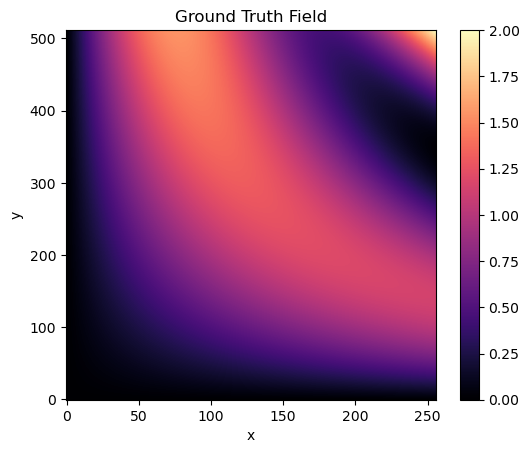

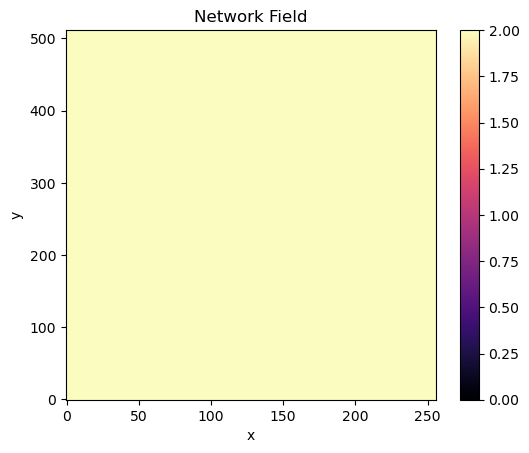

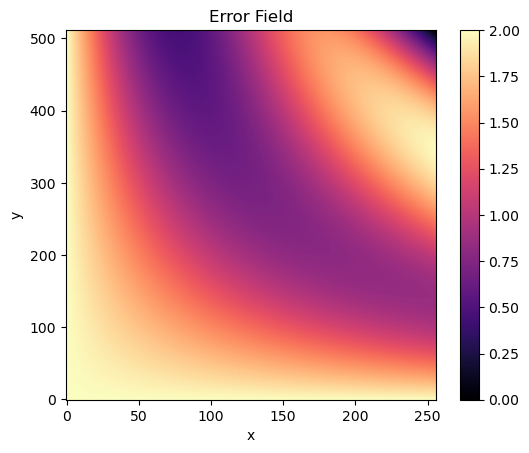

In [770]:
#This cell does question 1. A batch size of 3 is used, with only a single batch being required. Additional
#to the small forward pass which has its results printed, the randomly initialized network is plotted
#across the entire domain.

batchSize = 3

batchNo = 1

trainData_list = generateData(batchSize, batchNo)

weightsList , biasesList = initNetwork()

output = forward(weightsList , biasesList , trainData_list[0][0])

print("Network Output:")

print(output)

print("Ground Truth")

print(trainData_list[0][1])

vis(weightsList , biasesList)

#As we can see, the forward operations are working and the network is randomly initialized

#### Question 2

In [771]:
#This cell verifies that the gradients from forward and reverse AD are the same by calculating the
#gradients both ways for a batch size of 50 (batch number is 1 because we don't do any batching actually)
#and by printing the gradients of the first layer's weights for the first data point in the batch.
#Furthermore, a loop over all gradients is done and the maximum discrepancy is printed.

batchSize = 50

batchNo = 1

weightsList , biasesList = initNetwork()

trainData_list = generateData(batchSize, batchNo)

output , ds_dw_list , ds_db_list , da_ds_list , ds_da_list , losses , dl_da = forwardWithGraphCalculation(weightsList , biasesList , trainData_list[0][0] , trainData_list[0][1] , batchSize)

dl_dw_list_b , dl_db_list_b = backwardAD_dl_dws(ds_dw_list.copy() , ds_db_list.copy() , da_ds_list.copy() , ds_da_list.copy() , dl_da.copy() , batchSize)

dl_dw_list_f , dl_db_list_f = forwardAD_dl_dws(ds_dw_list.copy() , ds_db_list.copy() , da_ds_list.copy() , ds_da_list.copy() , dl_da.copy() , batchSize)

print("Backwards AD gradients of the first weight:")

print(dl_dw_list_b[0][0,:,:])

print("Forwards AD gradients of the first weight:")

print(dl_dw_list_f[0][0,:,:])

currentMax = 0

for i in range(forwardNo):

    maxErWeights = np.max(dl_dw_list_b[i] - dl_dw_list_f[i])

    maxErBiases = np.max(dl_db_list_b[i] - dl_db_list_f[i])

    if (maxErWeights > maxErBiases):

        maxErLayer = maxErWeights

    else:

        maxErLayer = maxErBiases

    if (maxErLayer > currentMax):

        currentMax = maxErLayer

print("Maximum Discrepancy in Gradients")

print(currentMax)

#As we can see, the displayed gradients are the same and the maximum discrepancy is likely due to machine
#prescision errors as it is so small

Backwards AD gradients of the first weight:
[[-9.47719445e-04  7.88582005e-07]
 [ 1.42261741e-05 -1.72547902e-04]
 [-4.93954670e-06 -1.66472210e-07]
 [-1.23380998e-04 -2.06012815e-05]
 [ 8.54257394e-05 -1.76415854e-05]
 [-1.80748925e-03  1.50398254e-06]
 [ 2.71321401e-05 -3.29083127e-04]
 [-9.42069683e-06 -3.17495574e-07]
 [-2.35312073e-04 -3.92907363e-05]
 [ 1.62923855e-04 -3.36460080e-05]]
Forwards AD gradients of the first weight:
[[-9.47719445e-04  7.88582005e-07]
 [ 1.42261741e-05 -1.72547902e-04]
 [-4.93954670e-06 -1.66472210e-07]
 [-1.23380998e-04 -2.06012815e-05]
 [ 8.54257394e-05 -1.76415854e-05]
 [-1.80748925e-03  1.50398254e-06]
 [ 2.71321401e-05 -3.29083127e-04]
 [-9.42069683e-06 -3.17495574e-07]
 [-2.35312073e-04 -3.92907363e-05]
 [ 1.62923855e-04 -3.36460080e-05]]
Maximum Discrepancy in Gradients
6.661338147750939e-16


In [772]:
#This cell times the different AD methods across 

testsToRun = 1000

batchSize = 100

batchNo = 1

dt_b_mean = 0

dt_f_mean = 0

for i in range(testsToRun):

    weightsList , biasesList = initNetwork()
    
    trainData_list = generateData(batchSize, batchNo)
    
    output , ds_dw_list , ds_db_list , da_ds_list , ds_da_list , losses , dl_da = forwardWithGraphCalculation(weightsList , biasesList , trainData_list[0][0] , trainData_list[0][1] , batchSize)

    t0 = time.time()
    
    dl_dw_list_b , dl_db_list_b = backwardAD_dl_dws(ds_dw_list.copy() , ds_db_list.copy() , da_ds_list.copy() , ds_da_list.copy() , dl_da.copy() , batchSize)

    t1 = time.time()

    dt_b_mean += t1-t0

    t0 = time.time()
    
    dl_dw_list_f , dl_db_list_f = forwardAD_dl_dws(ds_dw_list.copy() , ds_db_list.copy() , da_ds_list.copy() , ds_da_list.copy() , dl_da.copy() , batchSize)

    t1 = time.time()

    dt_f_mean += t1-t0

dt_b_mean /= testsToRun

dt_f_mean /= testsToRun

print("Mean Backwards AD Time (ms):")

print(dt_b_mean*1000)

print("Mean Forwards AD Time (ms):")

print(dt_f_mean*1000)

#As we can see, backwards AD is faster than forwards AD. They are closer than I thought they would be, and this is likely
#due to the small network size

Mean Backwards AD Time (ms):
3.2449352741241455
Mean Forwards AD Time (ms):
4.5035059452056885


#### Question 3

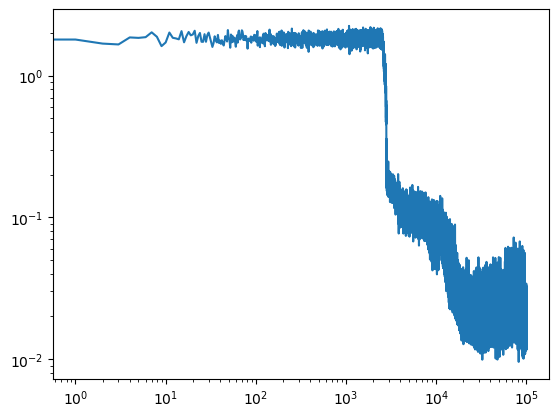

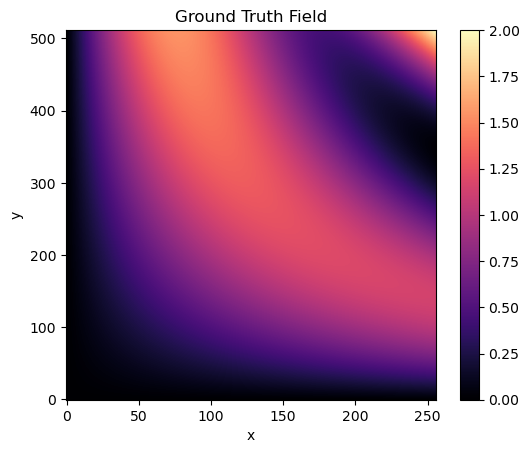

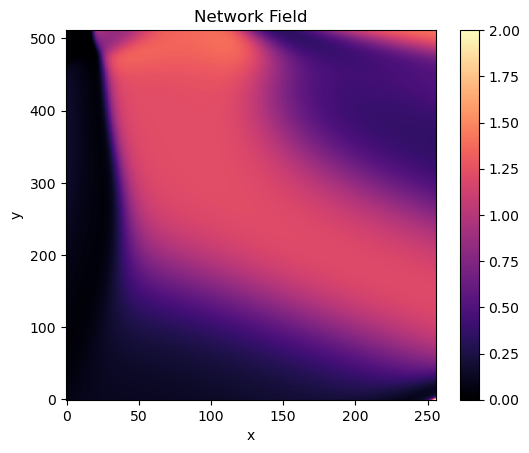

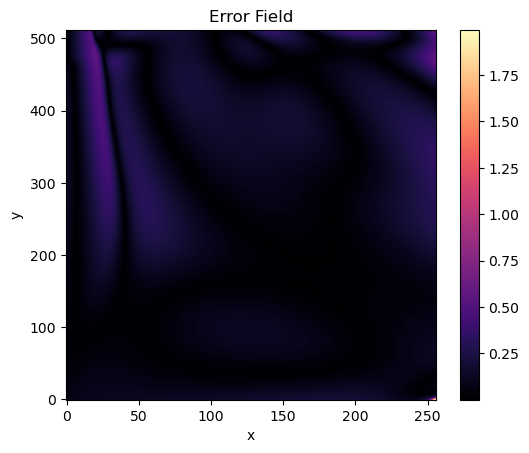

In [773]:
#This cell does it with backward AD

batchSize = 100

batchNo = 100000

direct = .01

momentum = .9

method = "backward"

weightsList , biasesList = initNetwork()

trainData_list = generateData(batchSize, batchNo)

weightsList , biasesList , lossList = gradientDescent(direct , momentum , weightsList , biasesList , trainData_list , batchNo , batchSize , method)

plt.loglog((np.array(lossList)).flatten())
plt.show()

vis(weightsList , biasesList)


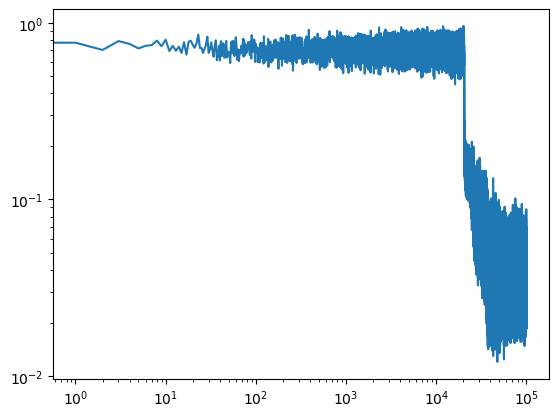

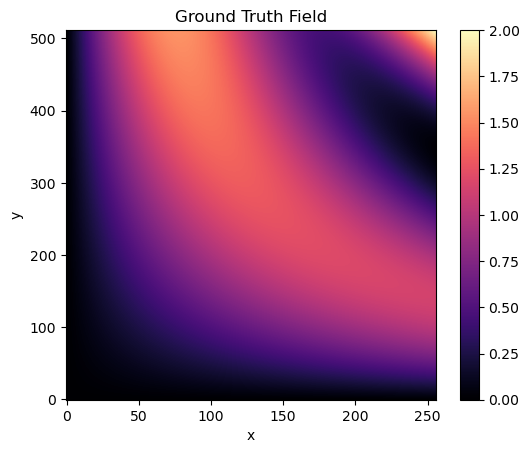

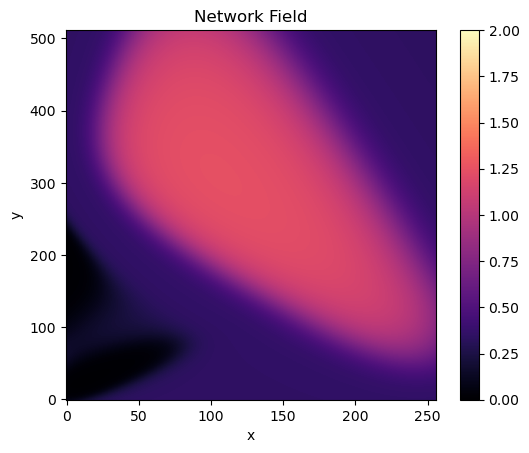

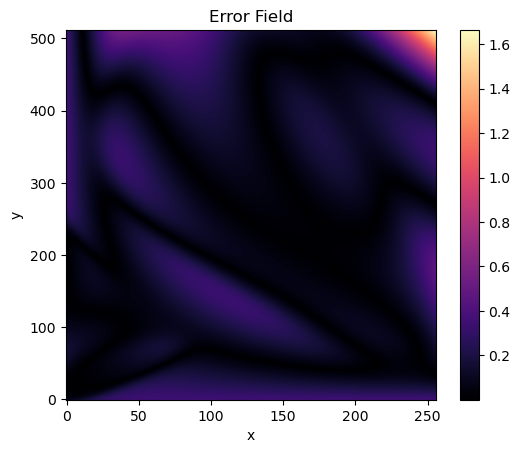

In [774]:
#This cell does it with forward AD

batchSize = 100

batchNo = 100000

direct = .01

momentum = .9

method = "forward"

weightsList , biasesList = initNetwork()

trainData_list = generateData(batchSize, batchNo)

weightsList , biasesList , lossList = gradientDescent(direct , momentum , weightsList , biasesList , trainData_list , batchNo , batchSize , method)

plt.loglog((np.array(lossList)).flatten())
plt.show()

vis(weightsList , biasesList)


In [775]:
#As you can see neither is very good. I couldn't get the hyper-parameters to work
#out super well. It actually works better with a smaller network. I assume this is just
#some side-effect of not having super optimized hyper-parameters or machine learning methods.

#As far as comparing them goes, they are both equally bad; however, they both get the general gist of
#the function correct.

#Also, the line plot for both of them is a loglog plot of loss vs optimization step.